In [1]:
from qiskit import QuantumCircuit, transpile, ClassicalRegister, QuantumRegister
from qiskit_aer import AerSimulator
from qiskit.visualization import plot_histogram

In [2]:
# Initialize quantum circuit with 3 qubits (psi, Alice, Bob)
qc = QuantumCircuit(3)

# Step 1: Prepare the quantum state |psi> = 0.8|0> + 0.6|1>
qc.initialize([0.8, 0.6], 0)
qc.barrier()

CircuitInstruction(operation=Instruction(name='barrier', num_qubits=3, num_clbits=0, params=[]), qubits=(Qubit(QuantumRegister(3, 'q'), 0), Qubit(QuantumRegister(3, 'q'), 1), Qubit(QuantumRegister(3, 'q'), 2)), clbits=())

Here, we have initialized our circuit with the 1st qubit being in the state 0.8|0> + 0.6|1>
***

In [3]:
# Step 2: Create a Bell state between Alice's second qubit and Bob's qubit
qc.h(1)            # Applying H gate on Alice's second qubit which turns it to |0> + |1> /sqrt2 as the default initial qubit is |0>
qc.cx(1, 2)        # CNOT with Alice's second qubit as control, Bob's as target
qc.barrier()

# Step 3: Manuplating Alice's quibits accorning to the protocol
qc.cx(0, 1)        # CNOT with original qubit (to be transferred) as control, Alice's other qubit as target
qc.h(0)            # Apply H gate on original qubit
qc.barrier()

# Allocate 2 classical bits for the measurements
qc.add_register(ClassicalRegister(1,"Zbit"))
qc.add_register(ClassicalRegister(1,"Xbit"))

# Perform measurements on the two qubits of Alice and store results in classical bits
qc.measure(0, 0) 
qc.measure(1, 1)
qc.barrier()


CircuitInstruction(operation=Instruction(name='barrier', num_qubits=3, num_clbits=0, params=[]), qubits=(Qubit(QuantumRegister(3, 'q'), 0), Qubit(QuantumRegister(3, 'q'), 1), Qubit(QuantumRegister(3, 'q'), 2)), clbits=())

Here we have initialized 2 different classical bits for storing the measured values of the first 2 qubits of Alice. Note that the 1st cbit is named Zbit because its value will control wheater to apply Z gate or not as it store the result of the original qubit. Similar is the case for Xbit
***

C:\Users\divya\AppData\Local\Temp\ipykernel_14448\2646493043.py:1: DeprecationWarning: The method ``qiskit.circuit.instructionset.InstructionSet.c_if()`` is deprecated as of qiskit 1.3.0. It will be removed in 2.0.0.
  qc.z(2).c_if(qc.cregs[0], 1)
C:\Users\divya\AppData\Local\Temp\ipykernel_14448\2646493043.py:2: DeprecationWarning: The method ``qiskit.circuit.instructionset.InstructionSet.c_if()`` is deprecated as of qiskit 1.3.0. It will be removed in 2.0.0.
  qc.x(2).c_if(qc.cregs[1], 1)


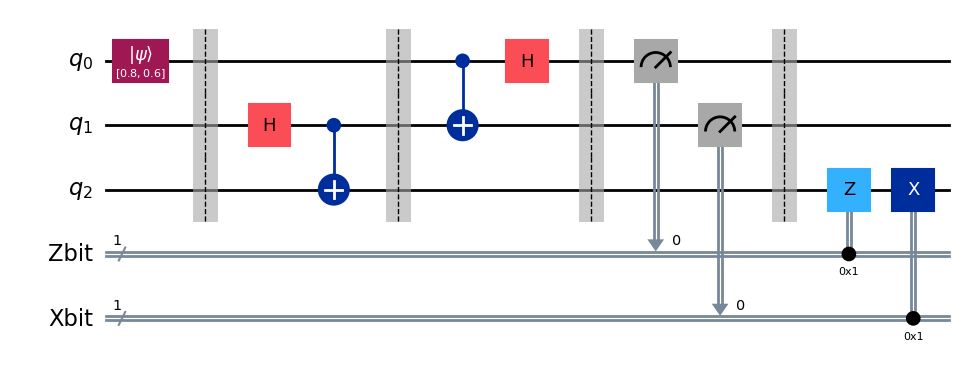

In [4]:
qc.z(2).c_if(qc.cregs[0], 1)
qc.x(2).c_if(qc.cregs[1], 1)

qc.draw("mpl")

Here we have made custom conditional gate, for the results of the first 2 qubits which applies Z and X gate on the 3rd qubit (Bob's qubit) depending on their value
***

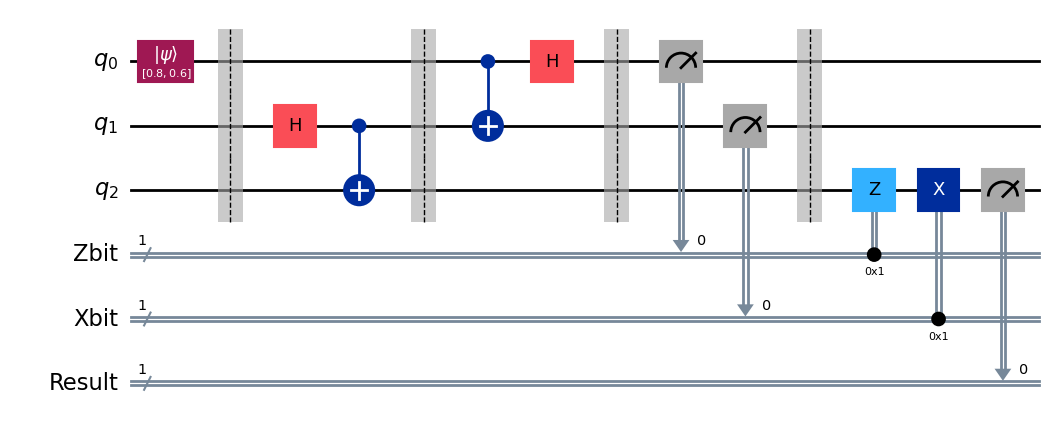

In [5]:
result = ClassicalRegister(1, "Result")
qc.add_register(result)
qc.measure(2, result)

qc.draw("mpl")

Last qubit is measured and stored in a cbit named 'Result'
***

In [18]:
result = AerSimulator().run(qc, shots= 1000).result()
statistics = result.get_counts()

Here we have ran our circuit on AER simulator (local machine) specifically sampling the 3 cbits 1000 times
***

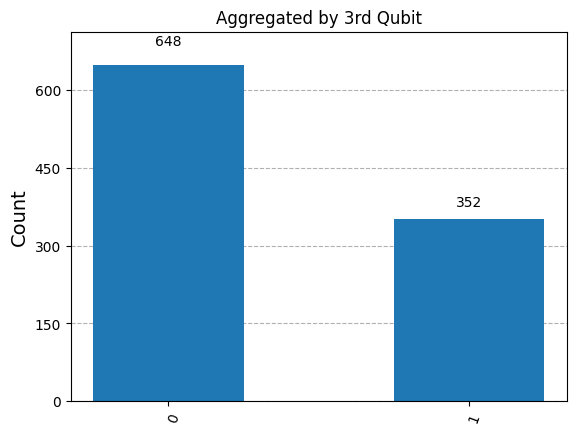

In [19]:
grouped_counts = {'0': 0, '1': 0}

for bitstring, count in statistics.items():
    if bitstring[0] == '0':
        grouped_counts['0'] += count
    else:  # If the least significant bit is 1
        grouped_counts['1'] += count

# Plot the aggregated histogram
display(plot_histogram(grouped_counts, title="Aggregated by 3rd Qubit"))

Since here all 8 cases of 3 qubit state vectors are possible hence we need to aggregate the casses where the 3rd qubit was 0 and the where it was 1. After dooing this we can see that Bob's qubit is zero 648 times and one 352 times out of 1000. The correct output would be that bob's qubit has the state 0.8|0> + 0.6|1> and hence the prob. of measuring it 0 should be (0.8)^2 = 64% while the chances of being 1 should be 36%. This is crearly the case for the above plot as it shows Bob's qubit being 0 approx. 64% (64.8% here) and its is 1 around 36% as well. Hence this validates that our quantum teleportation circuit actually works.
***

#
#
*Simulation on IBM's Quantum Computer*
***

In [8]:
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit_ibm_runtime import SamplerV2 as Sampler

In [9]:
from qiskit_ibm_runtime import QiskitRuntimeService

In [10]:
service = QiskitRuntimeService()
 
backend = service.least_busy(simulator=False, operational=True)
 
pm = generate_preset_pass_manager(backend=backend, optimization_level=1)
isa_circuit = pm.run(qc)

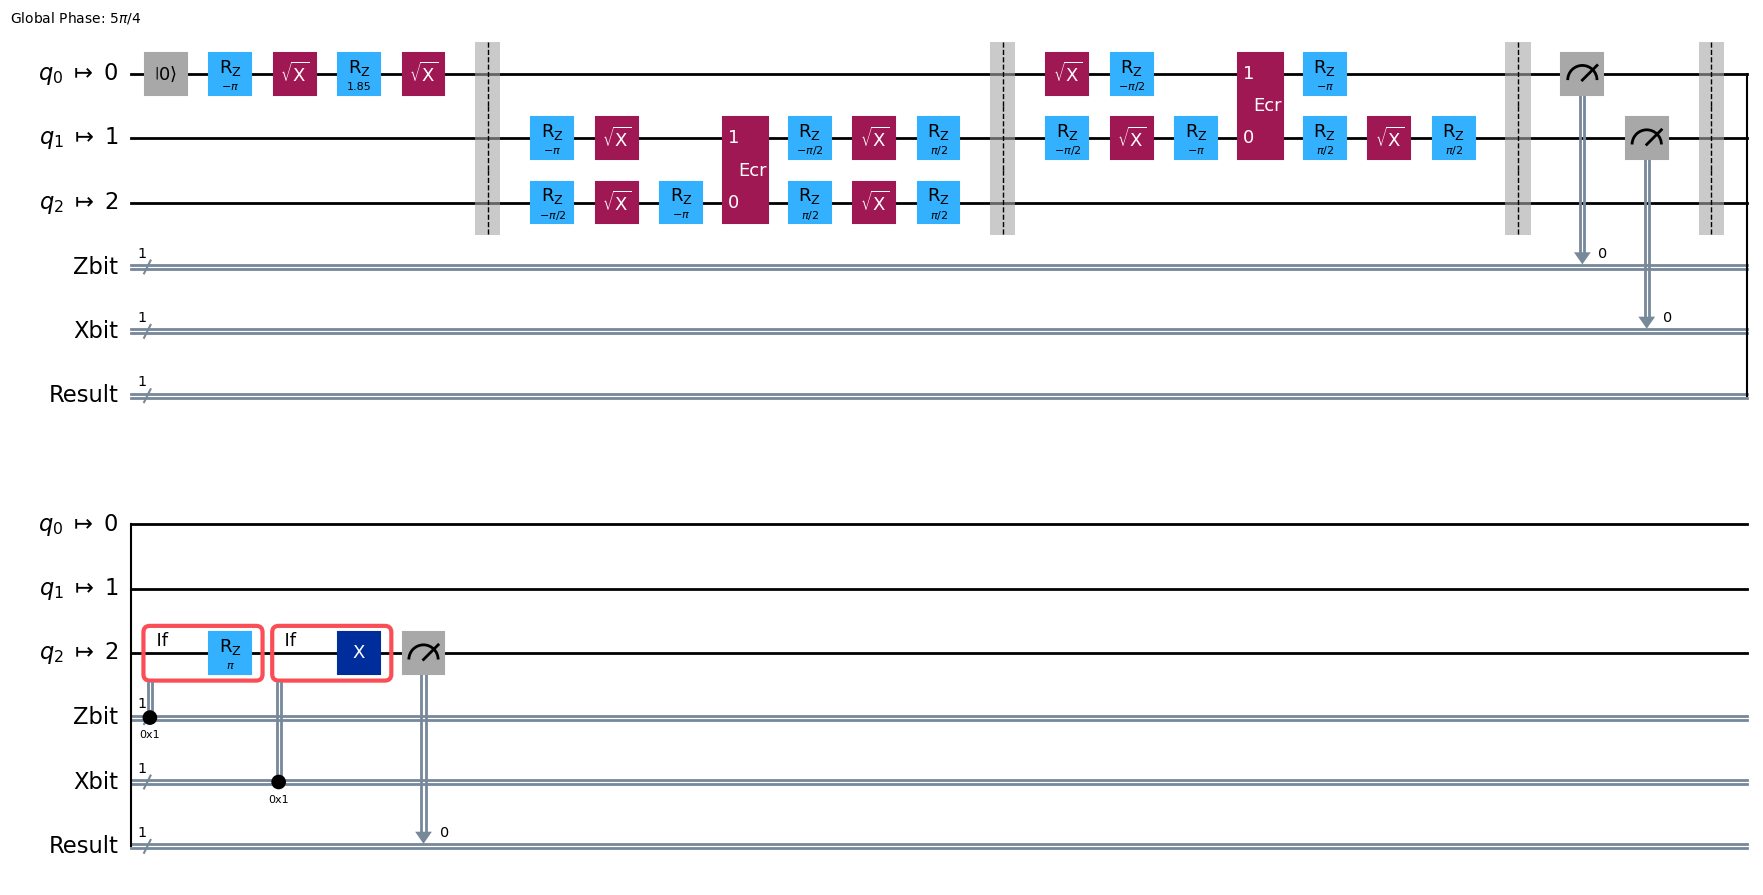

In [22]:
isa_circuit.draw("mpl", idle_wires=False)

Here we used IBM quantum computers as our backend machine where the circuit which we made will be simulated. Note that we have transpiled our circuit for the quantum computer i.e. we have optimized our circuit such that it should now reduce the numer of gates anywhere possible to make our circuit faster as well as being changed according to the hardware limitations of our quantum computers (It may be possible that some QC might have limted quantum gates and this transpilation changes our circuit to acomplish our task using only those gates compatible with the QC).
***

In [11]:
sampler = Sampler(mode=backend)
job = sampler.run([isa_circuit], shots=1000)
result = job.result()

Again similar to before, we have sampled our transpiled circuit 1000 times.
***

In [12]:
counts = result[0].data["Result"].get_counts()
print(f"The counts are: {counts}")

The counts are: {'0': 622, '1': 378}


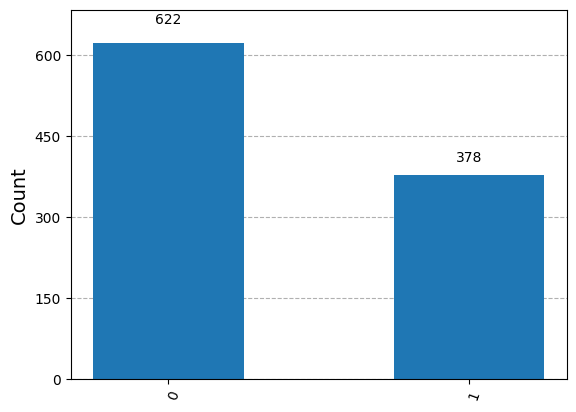

In [13]:
display(plot_histogram(counts))

Here since our ideal result is 64% of 1000 = 640 couts for 0 while 360 counts for 1. But as we cann see the resullts obtained although similar to ideal, doesn't give as accurate result as the aer simulator where the count for 0 & 1 were much closer to the actual value. This worse perfromance of Quantum computers were expected because by default, the aer simulator assumes a perfect, noise-free quantum system where the gates are applied with infinite precision and qubits don't decohere over time while on the other hand real quantum computers are noisy, and errors accumulate during their computation process, leading to less accurate results.
***